In [1]:
!pip uninstall https://test.pypi.org/simple/ simple-stein-svgd

Found existing installation: simple-stein-svgd 0.0.7
Uninstalling simple-stein-svgd-0.0.7:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/simple_stein_svgd-0.0.7.dist-info/*
    /usr/local/lib/python3.12/dist-packages/simple_stein_svgd/*
Proceed (Y/n)? Y
  Successfully uninstalled simple-stein-svgd-0.0.7


In [2]:
!pip install --extra-index-url https://pypi.org/simple/ -i https://test.pypi.org/simple/ simple-stein-svgd

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/


In [3]:
import numpy as np
from simple_stein_svgd import (
    SVGD, list_kernels, list_bandwidth_rules,
    bandwidth_median, bandwidth_scott, bandwidth_silverman
)

def log_prob_2d_mog(X):
    mu1 = np.array([2.0, 2.0])
    mu2 = np.array([-2.0, -2.0])
    cov1 = np.array([[1.0, 0.3],[0.3, 1.0]])
    cov2 = np.array([[1.5, -0.2],[-0.2, 1.0]])

    def logn(x, mu, cov_inv):
        diff = x - mu
        return -0.5 * np.sum(diff @ cov_inv * diff, axis=1)

    cov1_inv = np.linalg.inv(cov1)
    cov2_inv = np.linalg.inv(cov2)

    l1 = logn(X, mu1, cov1_inv)
    l2 = logn(X, mu2, cov2_inv)
    m = np.maximum(l1, l2)
    return (m + np.log(np.exp(l1 - m) + np.exp(l2 - m)))


In [4]:
def run_svgd_once(kernel_name, bw_rule=None, n=256, d=2, T=200, stepsize=0.05, seed=7):
    rng = np.random.default_rng(seed)
    X = rng.normal(0, 3.0, size=(n, d))

    if bw_rule is None:
        svgd = SVGD(log_prob_2d_mog, kernel=kernel_name)
    else:
        svgd = SVGD(log_prob_2d_mog, kernel=kernel_name, bandwidth_rule=bw_rule)

    ksd_hist, time_hist = [], []
    for t in range(T):
        res = svgd.update(X, stepsize=stepsize)
        X = res.particles
        ksd_hist.append(res.ksd)
        time_hist.append(res.wall_time)
        if (t+1) % 20 == 0:
            print(f"[{kernel_name}] iter {t+1:3d} | KSD={res.ksd:.6f} | wall={res.wall_time*1e3:.2f} ms")
    return np.array(ksd_hist), np.array(time_hist), X


In [5]:
print("Kernels:", sorted(list_kernels().keys()))
print("Bandwidth rules:", sorted(list_bandwidth_rules().keys()))


Kernels: ['imq', 'linear', 'rbf']
Bandwidth rules: ['median', 'scott', 'silverman']


In [6]:
results = {}
for kname in ["rbf", "imq", "linear"]:
    ksd_hist, time_hist, Xf = run_svgd_once(kname)
    results[kname] = {"ksd": ksd_hist, "wall": time_hist, "final": Xf}

{key: (float(v["ksd"][-1]), float(np.mean(v["wall"])*1e3)) for key, v in results.items()}


[rbf] iter  20 | KSD=0.544588 | wall=20.24 ms
[rbf] iter  40 | KSD=0.488352 | wall=20.79 ms
[rbf] iter  60 | KSD=0.439142 | wall=21.35 ms
[rbf] iter  80 | KSD=0.395612 | wall=28.95 ms
[rbf] iter 100 | KSD=0.357225 | wall=23.60 ms
[rbf] iter 120 | KSD=0.324628 | wall=20.92 ms
[rbf] iter 140 | KSD=0.299902 | wall=20.13 ms
[rbf] iter 160 | KSD=0.286158 | wall=20.48 ms
[rbf] iter 180 | KSD=0.285954 | wall=20.26 ms
[rbf] iter 200 | KSD=0.299545 | wall=20.30 ms
[imq] iter  20 | KSD=0.443457 | wall=33.76 ms
[imq] iter  40 | KSD=0.419459 | wall=33.46 ms
[imq] iter  60 | KSD=0.396458 | wall=32.69 ms
[imq] iter  80 | KSD=0.374507 | wall=33.06 ms
[imq] iter 100 | KSD=0.353636 | wall=33.25 ms
[imq] iter 120 | KSD=0.333565 | wall=50.48 ms
[imq] iter 140 | KSD=0.315270 | wall=49.70 ms
[imq] iter 160 | KSD=0.298453 | wall=33.20 ms
[imq] iter 180 | KSD=0.283272 | wall=33.91 ms
[imq] iter 200 | KSD=0.270099 | wall=34.29 ms
[linear] iter  20 | KSD=1.010673 | wall=3.20 ms
[linear] iter  40 | KSD=0.980716

{'rbf': (0.2995449638716997, 23.973252890009462),
 'imq': (0.27009877529473086, 38.640278634989045),
 'linear': (0.9502643526737177, 3.47645325501162)}

In [7]:
ksd_median, _, _ = run_svgd_once("rbf", bw_rule=bandwidth_median)
ksd_scott,  _, _ = run_svgd_once("rbf", bw_rule=bandwidth_scott)
ksd_silv,   _, _ = run_svgd_once("rbf", bw_rule=bandwidth_silverman)

print("Final KSD (median, scott, silverman):",
      float(ksd_median[-1]), float(ksd_scott[-1]), float(ksd_silv[-1]))


[rbf] iter  20 | KSD=0.544588 | wall=20.80 ms
[rbf] iter  40 | KSD=0.488352 | wall=20.60 ms
[rbf] iter  60 | KSD=0.439142 | wall=20.64 ms
[rbf] iter  80 | KSD=0.395612 | wall=21.18 ms
[rbf] iter 100 | KSD=0.357225 | wall=21.46 ms
[rbf] iter 120 | KSD=0.324628 | wall=21.90 ms
[rbf] iter 140 | KSD=0.299902 | wall=29.26 ms
[rbf] iter 160 | KSD=0.286158 | wall=21.14 ms
[rbf] iter 180 | KSD=0.285954 | wall=20.56 ms
[rbf] iter 200 | KSD=0.299545 | wall=20.63 ms
[rbf] iter  20 | KSD=0.424046 | wall=23.43 ms
[rbf] iter  40 | KSD=0.409618 | wall=23.18 ms
[rbf] iter  60 | KSD=0.396140 | wall=22.71 ms
[rbf] iter  80 | KSD=0.383501 | wall=24.07 ms
[rbf] iter 100 | KSD=0.371835 | wall=23.16 ms
[rbf] iter 120 | KSD=0.361686 | wall=14.07 ms
[rbf] iter 140 | KSD=0.354238 | wall=14.75 ms
[rbf] iter 160 | KSD=0.351585 | wall=13.97 ms
[rbf] iter 180 | KSD=0.356759 | wall=14.01 ms
[rbf] iter 200 | KSD=0.373033 | wall=14.23 ms
[rbf] iter  20 | KSD=0.424046 | wall=13.93 ms
[rbf] iter  40 | KSD=0.409618 | wa

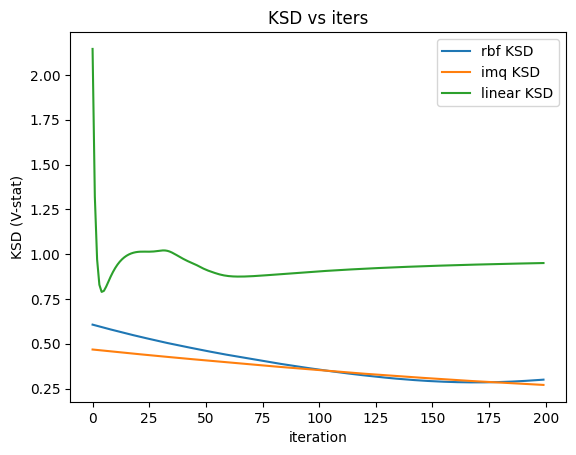

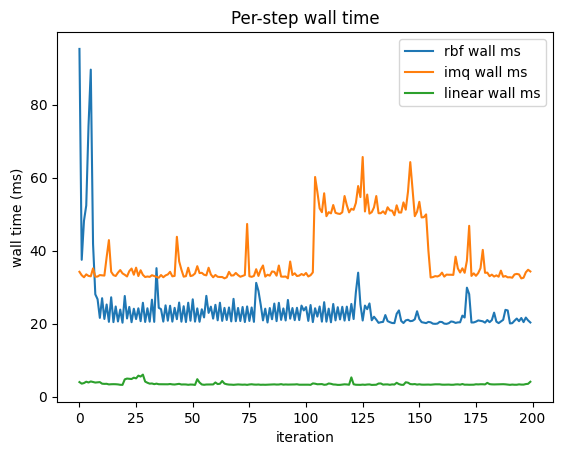

In [8]:
import matplotlib.pyplot as plt

plt.figure()
for k in ["rbf","imq","linear"]:
    plt.plot(results[k]["ksd"], label=f"{k} KSD")
plt.xlabel("iteration"); plt.ylabel("KSD (V-stat)"); plt.legend(); plt.title("KSD vs iters")
plt.show()

plt.figure()
for k in ["rbf","imq","linear"]:
    plt.plot(results[k]["wall"]*1e3, label=f"{k} wall ms")
plt.xlabel("iteration"); plt.ylabel("wall time (ms)"); plt.legend(); plt.title("Per-step wall time")
plt.show()
